# Comparing Support Vector Machines, Decision Trees and Naive Bayes for Heart Failure Prediction

In [114]:
# Notebook for Workshop: Compare Support Vector Machines, DTs and NB
# https://hiof.instructure.com/courses/8923/assignments/41776?module_item_id=283971

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import GridSearchCV

In [115]:
pd.set_option("display.max_columns", None)

I've added some markdown cells that provide some tips into how to discuss results. Note that my comments were made to a
particular run. Due the limitations with setup related to random sampling, we get different results each time we run. The discussions might therefore be slightly errornous when discussion concrete numbers, but they still provide valuable tips for how to discuss results.

In [116]:
# Load the dataset and show first 5 rows

dataset = pd.read_csv('../data/heart_failure/heart_failure_clinical_records_dataset.csv')
dataset.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


## Exploratory Analysis and Processing

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'anaemia'}>,
        <Axes: title={'center': 'creatinine_phosphokinase'}>,
        <Axes: title={'center': 'diabetes'}>],
       [<Axes: title={'center': 'ejection_fraction'}>,
        <Axes: title={'center': 'high_blood_pressure'}>,
        <Axes: title={'center': 'platelets'}>,
        <Axes: title={'center': 'serum_creatinine'}>],
       [<Axes: title={'center': 'serum_sodium'}>,
        <Axes: title={'center': 'sex'}>,
        <Axes: title={'center': 'smoking'}>,
        <Axes: title={'center': 'time'}>],
       [<Axes: title={'center': 'DEATH_EVENT'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

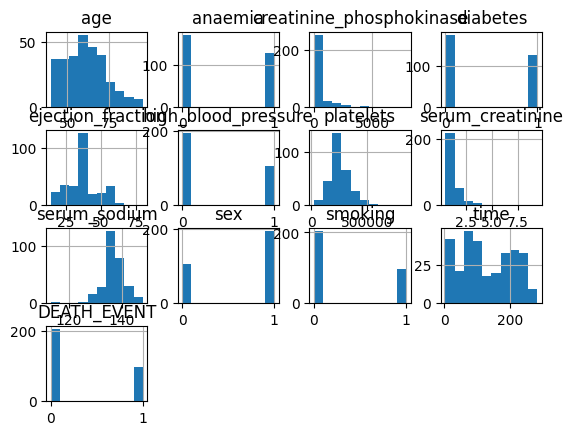

In [117]:
# Show the distribution of all the columns (both features and targets). We do this 
# to explore our data so that we better know how to proceed with the training. 
# This should be improved.

dataset.hist()

We did this analysis to determine which version of naive bayes to use. We can see that some of the features are what we can consider normally distributed and some are binary. The normally distributed features aren't necessarily bell shaped like we would expect for normally distributed data, but they are closer to normally distributed than the alternative (binary/frequency).

The fact that we have two different types of distributions in our features means that we might have to create a custom classifier that combines a gaussian and bernoulli classifier to achieve optimal performance.

## Training & Tuning

In [118]:
# Split into 60/20/20. 60% for training, 20% validation, and 20% for final testing

trainval = dataset.groupby('DEATH_EVENT', group_keys=False)[dataset.columns].apply(lambda x: x.sample(frac=0.8))
test = dataset.drop(trainval.index)

In [119]:
# Separate input features from targets in all partitions

trainval_features = trainval.drop('DEATH_EVENT', axis=1)
trainval_targets = trainval['DEATH_EVENT']

test_features = test.drop('DEATH_EVENT', axis=1)
test_targets = test.DEATH_EVENT

In [120]:
# A custom function for evaluation the performance using accuracy, precision, recall, f1 and roc_auc
# The final_eval parameter makes the evaluation include test data
def evaluate(model, final_eval=False):

    # Store the prediction probabilites and the predictions. We need the probabilities for 
    # roc_auc_score metric

    train_probabilities = model.predict_proba(trainval_features)
    # train_predictions = model.predict(train_features)
    # This does the same as the statement above without having the model predict again
    train_predictions = model.classes_.take(np.argmax(train_probabilities, axis=1), axis=0)
    validation_probabilities = model.predict_proba(validation_features)
    # validation_predictions = model.predict(validation_features)
    validation_predictions = model.classes_.take(np.argmax(validation_probabilities, axis=1), axis=0)

    # Print the training and validation scores

    print(f'Training Accuracy: {accuracy_score(train_targets, train_predictions)}')
    print(f'Training Precision: {precision_score(train_targets, train_predictions)}')
    print(f'Training Recall: {recall_score(train_targets, train_predictions)}')
    print(f'Training F1: {f1_score(train_targets, train_predictions)}')
    print(f'Training ROC AUC: {roc_auc_score(train_targets, train_probabilities[:,1])}')
    print(f'Validation Accuracy: {accuracy_score(validation_targets, validation_predictions)}')
    print(f'Validation Precision: {precision_score(validation_targets, validation_predictions)}')
    print(f'Validation Recall: {recall_score(validation_targets, validation_predictions)}')
    print(f'Validation F1: {f1_score(validation_targets, validation_predictions)}')
    print(f'Validation ROC AUC: {roc_auc_score(validation_targets, validation_probabilities[:,1])}')
    
    # Evaluate and print the final test scores if final_eval is True
    
    if final_eval:
        test_probabilities = model.predict_proba(test_features)
        test_predictions = model.classes_.take(np.argmax(test_probabilities, axis=1), axis=0)

        print(f'Test Accuracy: {accuracy_score(test_targets, test_predictions)}')
        print(f'Test Precision: {precision_score(test_targets, test_predictions)}')
        print(f'Test Recall: {recall_score(test_targets, test_predictions)}')
        print(f'Test F1: {f1_score(test_targets, test_predictions)}')
        print(f'Test ROC AUC: {roc_auc_score(test_targets, test_probabilities[:,1])}')
    print()

Observations:
* model1 is highly overfitted, test results for f1 has dropped with almost 28 percentage points, other metrics have dropped significantly
* the model has a slignt tendency towards precision, meaning that the it is restrictive in predicting heart failures but that it is quite accurate when making the prediction


In [121]:
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

In [122]:

dt_params = {
    'criterion': ['gini', 'entropy'], 
    'max_depth': range(1,21)
    # Needs to be expanded with more parameters
}
dt_grid = GridSearchCV(DecisionTreeClassifier(), dt_params, scoring=metrics, refit='f1')

dt_grid.fit(trainval_features, trainval_targets)

dt_cv_results = pd.DataFrame(dt_grid.cv_results_)
dt_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
0,0.001570,0.000796,0.006661,0.003237,gini,1,"{'criterion': 'gini', 'max_depth': 1}",0.854167,0.916667,0.791667,0.812500,0.829787,0.840957,0.043059,1,0.900000,1.000000,0.714286,0.818182,0.769231,0.840340,0.100487,1,0.600000,0.733333,0.6250,0.5625,0.666667,0.637500,0.058689,11,0.720000,0.846154,0.666667,0.666667,0.714286,0.722755,0.065724,1,0.784848,0.866667,0.750000,0.750000,0.786458,0.787595,0.042633,6
1,0.001183,0.000045,0.004732,0.000079,gini,2,"{'criterion': 'gini', 'max_depth': 2}",0.854167,0.875000,0.708333,0.791667,0.765957,0.799025,0.060308,6,0.900000,0.764706,0.550000,0.687500,0.611111,0.702663,0.122237,6,0.600000,0.866667,0.6875,0.6875,0.733333,0.715000,0.087266,1,0.720000,0.812500,0.611111,0.687500,0.666667,0.699556,0.066669,5,0.925253,0.917172,0.654297,0.784180,0.807292,0.817638,0.099393,3
2,0.001247,0.000041,0.004708,0.000045,gini,3,"{'criterion': 'gini', 'max_depth': 3}",0.875000,0.833333,0.729167,0.750000,0.765957,0.790691,0.054734,7,0.909091,0.769231,0.615385,0.666667,0.625000,0.717075,0.110408,5,0.666667,0.666667,0.5000,0.5000,0.666667,0.600000,0.081650,33,0.769231,0.714286,0.551724,0.571429,0.645161,0.650366,0.082708,9,0.913131,0.753535,0.685547,0.736328,0.855208,0.788750,0.083098,5
3,0.001308,0.000031,0.004752,0.000067,gini,4,"{'criterion': 'gini', 'max_depth': 4}",0.833333,0.750000,0.687500,0.791667,0.765957,0.765691,0.048188,18,0.684211,0.615385,0.533333,0.714286,0.625000,0.634443,0.062494,22,0.866667,0.533333,0.5000,0.6250,0.666667,0.638333,0.129056,9,0.764706,0.571429,0.516129,0.666667,0.645161,0.632818,0.084944,16,0.862626,0.649495,0.472656,0.834961,0.796875,0.723323,0.145302,20
4,0.001385,0.000024,0.004798,0.000081,gini,5,"{'criterion': 'gini', 'max_depth': 5}",0.812500,0.750000,0.666667,0.729167,0.787234,0.749113,0.050333,28,0.666667,0.615385,0.500000,0.615385,0.631579,0.605803,0.056119,29,0.800000,0.533333,0.4375,0.5000,0.800000,0.614167,0.154821,22,0.727273,0.571429,0.466667,0.551724,0.705882,0.604595,0.098213,30,0.797980,0.594949,0.520508,0.772461,0.809375,0.699055,0.118374,35
5,0.001422,0.000030,0.004754,0.000103,gini,6,"{'criterion': 'gini', 'max_depth': 6}",0.791667,0.750000,0.645833,0.750000,0.808511,0.749202,0.056581,27,0.647059,0.636364,0.470588,0.642857,0.650000,0.609374,0.069544,26,0.733333,0.466667,0.5000,0.5625,0.866667,0.625833,0.151483,15,0.687500,0.538462,0.484848,0.600000,0.742857,0.610733,0.094377,29,0.771717,0.723232,0.546875,0.749023,0.821875,0.722545,0.093644,22
6,0.001427,0.000043,0.004736,0.000150,gini,7,"{'criterion': 'gini', 'max_depth': 7}",0.791667,0.791667,0.604167,0.791667,0.744681,0.744770,0.072618,30,0.666667,0.692308,0.421053,0.687500,0.578947,0.609295,0.102620,27,0.666667,0.600000,0.5000,0.6875,0.733333,0.637500,0.081052,11,0.666667,0.642857,0.457143,0.687500,0.647059,0.620245,0.083079,24,0.752525,0.739394,0.578125,0.765625,0.741667,0.715467,0.069298,28
7,0.001398,0.000027,0.004685,0.000094,gini,8,"{'criterion': 'gini', 'max_depth': 8}",0.770833,0.791667,0.583333,0.729167,0.765957,0.728191,0.075178,36,0.625000,0.692308,0.388889,0.600000,0.611111,0.583462,0.102440,35,0.666667,0.600000,0.4375,0.5625,0.733333,0.600000,0.100035,31,0.645161,0.642857,0

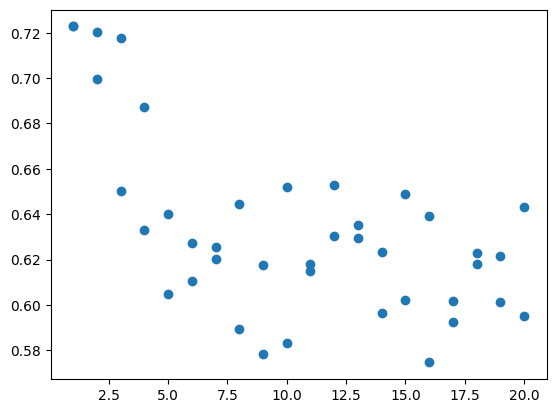

In [123]:
plt.scatter(dt_cv_results['param_max_depth'], dt_cv_results['mean_test_f1'])

Observations
* This model is overfitted as well, but not to the same extent as the dt1 
* Like the first model, the model has better precision than recall, but here the tendency is much greater and we can see the trend in both the training and test results
* dt2 performs better than dt1 in all metrics (the same for recall) for validation data i.e. we must assume it is the best of the two

In [124]:
# Calculate the confusion matrix for the best decision tree model.

confusion_matrix(test_targets, dt_grid.predict(test_features))

array([[38,  3],
       [ 5, 14]])

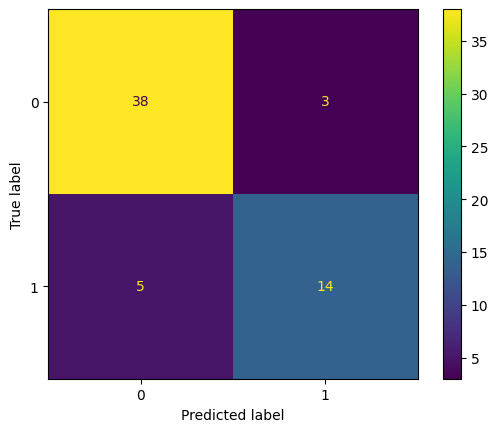

In [125]:
# The ConfusionMatrixDisplay class can be used to make confusion matrix plots

ConfusionMatrixDisplay.from_estimator(dt_grid, test_features, test_targets)

The confusion matrix show that dt2 is very accurate in it's predictions (precision), only two false positives. There are however 9 false negatives i.e. 9 failures that wasn't predicted. This could have dramatic consequences in practice.

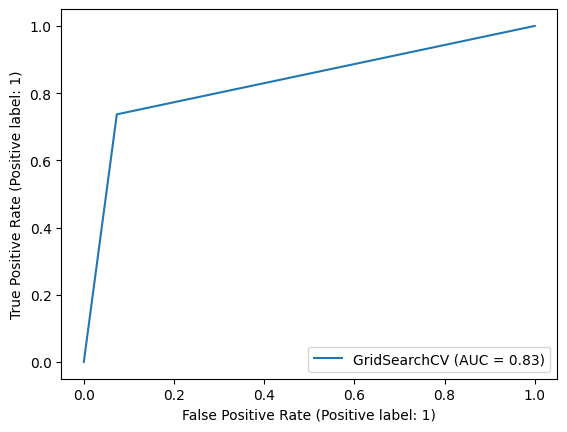

In [126]:
# Plot the ROC curve for the best decision tree model

# These two statements achieves the same thing
# RocCurveDisplay.from_predictions(test_targets, dt2.predict_proba(test_features)[:,1])
RocCurveDisplay.from_estimator(dt_grid, test_features, test_targets)

The ROC curve show very good performance for all sensitivities. This is also shown by the AUC of 0.84

In [127]:
# Train and evaluate a gaussian naive bayesian classifier with default parameters

nb_params = {
    'var_smoothing': np.logspace(1e-11, 1e-7)
}
nb_grid = GridSearchCV(GaussianNB(), nb_params, scoring=metrics, refit='f1')
nb_grid.fit(trainval_features, trainval_targets)
nb_cv_results = pd.DataFrame(nb_grid.cv_results_)
nb_cv_results

/home/lars/.venv/sklearn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lars/.venv/sklearn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lars/.venv/sklearn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lars/.venv/sklearn/lib/python3.11/site-packages/sklearn/metrics/_classification

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_var_smoothing,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
0,0.001201,0.000103,0.005120,0.000393,1.0,{'var_smoothing': 1.0000000000230258},0.6875,0.6875,0.645833,0.666667,0.680851,0.67367,0.015862,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.608081,0.533333,0.664062,0.464844,0.545833,0.563231,0.067904,1
1,0.001125,0.000040,0.004824,0.000114,1.0,{'var_smoothing': 1.0000000047217092},0.6875,0.6875,0.645833,0.666667,0.680851,0.67367,0.015862,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.608081,0.533333,0.664062,0.464844,0.545833,0.563231,0.067904,1
2,0.001094,0.000037,0.004798,0.000140,1.0,{'var_smoothing': 1.0000000094203925},0.6875,0.6875,0.645833,0.666667,0.680851,0.67367,0.015862,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.608081,0.533333,0.664062,0.464844,0.545833,0.563231,0.067904,1
3,0.001075,0.000027,0.004726,0.000107,1.0,{'var_smoothing': 1.000000014119076},0.6875,0.6875,0.645833,0.666667,0.680851,0.67367,0.015862,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.608081,0.533333,0.664062,0.464844,0.545833,0.563231,0.067904,1
4,0.001081,0.000033,0.004660,0.000086,1.0,{'var_smoothing': 1.0000000188177594},0.6875,0.6875,0.645833,0.666667,0.680851,0.67367,0.015862,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.608081,0.533333,0.664062,0.464844,0.545833,0.563231,0.067904,1
5,0.001076,0.000034,0.004728,0.000124,1.0,{'var_smoothing': 1.0000000235164428},0.6875,0.6875,0.645833,0.666667,0.680851,0.67367,0.015862,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.608081,0.533333,0.664062,0.464844,0.545833,0.563231,0.067904,1
6,0.001153,0.000128,0.004841,0.000210,1.0,{'var_smoothing': 1.0000000282151262},0.6875,0.6875,0.645833,0.666667,0.680851,0.67367,0.015862,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.608081,0.533333,0.664062,0.464844,0.545833,0.563231,0.067904,1
7,0.001077,0.000030,0.004745,0.000099,1.0,{'var_smoothing': 1.0000000329138097},0.6875,0.6875,0.645833,0.666667,0.680851,0.67367,0.015862,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.608081,0.533333,0.664062,0.464844,0.545833,0.563231,0.067904,1
8,0.001098,0.000020,0.004658,0.000010,1.0,{'var_smoothing': 1.0000000376124933},0.6875,0.6875,0.645833,0.666667,0.680851,0.67367,0.015862,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.608081,0.533333,0.664062,0.464844,0.545833,0.563231,0.067904,1
9,0.001068,0.000014,0.004648,0.000015,1.0,{'var_smoothing': 1.0000000423111768},0.6875,0.6875,0.645833,0.666667,0.680851,0.67367,0.015862,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.608081,0.533333,0.664062,0.464844,0.545833,0.563231,0.067904,1


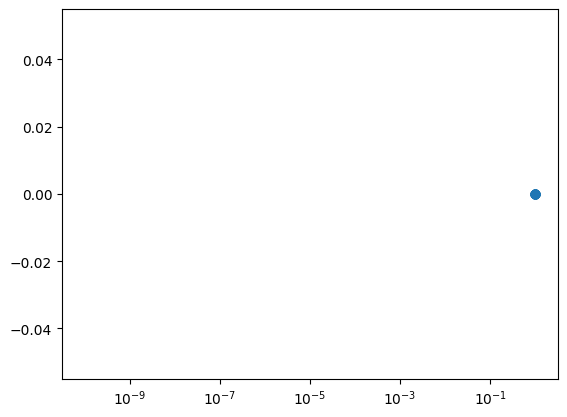

In [128]:
fig, ax = plt.subplots(1,1)
ax.semilogx(1e-10, 0)
plt.scatter(nb_cv_results['param_var_smoothing'], nb_cv_results['mean_test_f1'])

* The two models performs exactly the same on test data, which makes us have to fall back to validation data in determining which models is the best
* nb1 is the better of the two for validation data. (Individual metrics should be discussed)

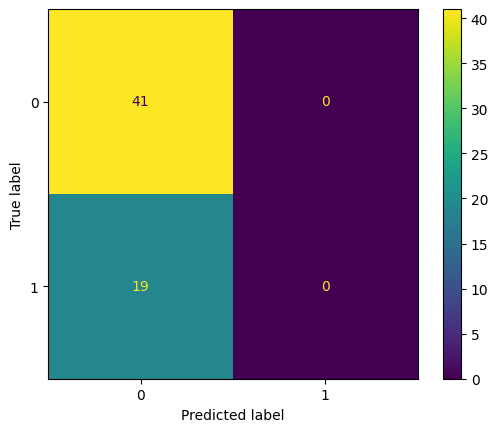

In [129]:
# Plot the confusion matrix for the best NB

ConfusionMatrixDisplay.from_estimator(nb_grid, test_features, test_targets)

In [130]:
RocCurveDisplay.from_estimator(nb1, test_features, test_targets)

NotFittedError: This GaussianNB instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [132]:
svc_params = {
    'C': [0.1, 0.5, 1.0]
}
svc_grid = GridSearchCV(SVC(), svc_params, scoring=metrics, refit='f1')
svc_grid.fit(trainval_features, trainval_targets)
svc_cv_results = pd.DataFrame(svc_grid.cv_results_)
svc_cv_results

/home/lars/.venv/sklearn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lars/.venv/sklearn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lars/.venv/sklearn/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lars/.venv/sklearn/lib/python3.11/site-packages/sklearn/metrics/_classification

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
0,0.001909,0.000499,0.006020,0.000967,0.1,{'C': 0.1},0.6875,0.6875,0.666667,0.666667,0.680851,0.677837,0.009438,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.606061,0.458586,0.470703,0.482422,0.466667,0.496888,0.055125,3
1,0.002192,0.000209,0.007056,0.001347,0.5,{'C': 0.5},0.6875,0.6875,0.666667,0.666667,0.680851,0.677837,0.009438,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.480808,0.490909,0.554688,0.513672,0.479167,0.503849,0.028244,2
2,0.002025,0.000160,0.005665,0.000373,1.0,{'C': 1.0},0.6875,0.6875,0.666667,0.666667,0.680851,0.677837,0.009438,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.505051,0.480808,0.568359,0.552734,0.416667,0.504724,0.054186,1


In [133]:
# Here you should add a collected presentation of all the results to make it easy to make the final 
# conclusion. I've kept it simple here by only showing the evaluation for the best classifiers of 
# both type

evaluate(dt_grid, final_eval=True)
evaluate(nb_grid, final_eval=True)
evaluate(svc_grid, final_eval=True)

NameError: name 'train_features' is not defined

Based on the metrics shown above we have to conclude that that dt2 is the best classifier for predicting heart failures. Both the confusion matrices and the ROC plots confirm the results. Both classifiers have a significant amount of false negatives, which makes both models complicate to implement in healthcare practice. 

The results are highly dependent on the random sampling in the data partitions. A more thorough analysis is needed to overcome this issue.